In [9]:
lithology_numbers = {30000: {'lith':'Sandstone', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                 65030: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 65000: {'lith':'Shale', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                 80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 74000: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                 70000: {'lith':'Limestone', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 70032: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                 99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 90000: {'lith':'Coal', 'lith_num':11, 'hatch':'', 'color':'black'}}

In [2]:
# ==============================================
# ===== GPU check & setup (run first) ==========
# ==============================================
import subprocess, sys, torch, numpy as np

print("Python:", sys.version)
try:
    print(subprocess.check_output(["nvidia-smi", "-L"]).decode())
    print(subprocess.check_output(["nvidia-smi"]).decode().splitlines()[:5])
except Exception as e:
    print("nvidia-smi not available:", e)

print("torch.cuda.is_available():", torch.cuda.is_available())
if torch.cuda.is_available():
    print("torch.cuda.get_device_name(0):", torch.cuda.get_device_name(0))

# Helper to enforce float32 for GPU models
def to_f32(a):
    return np.asarray(a, dtype=np.float32)


Python: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
GPU 0: Quadro T1000 with Max-Q Design (UUID: GPU-23ada542-3a0e-d690-ac21-b6b712a84256)

['Thu Oct  2 08:02:48 2025       ', '+-----------------------------------------------------------------------------------------+', '| NVIDIA-SMI 573.44                 Driver Version: 573.44         CUDA Version: 12.8     |', '|-----------------------------------------+------------------------+----------------------+', '| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |']
torch.cuda.is_available(): False


In [7]:
# ==============================================
# ===== Load & preprocess dataset ==============
# ==============================================
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

DATASET_PATH = "train.csv"
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

df = pd.read_csv(DATASET_PATH)
print("Dataset:", DATASET_PATH, "rows:", len(df))

# Encode GROUP, FORMATION, but keep WELL for grouping
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-numeric columns:", non_numeric_columns)

for col in non_numeric_columns:
    if col == "WELL":
        print("Keeping WELL for grouping (not encoded).")
        continue
    df[col] = df[col].astype(str).fillna("MISSING")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    print(f"Encoded {col} -> {df[col].nunique()} classes")

print("Processed shape:", df.shape)

# Outlier handling
if "GR" in df: df["GR"] = df["GR"].clip(upper=300)
if "RHOB" in df: df["RHOB"] = df["RHOB"].clip(1.8, 3.2)

# Resistivity log transform
for col in ["RDEP", "RMED", "RSHA"]:
    if col in df:
        df[col] = df[col].apply(lambda x: np.log10(x + 1) if pd.notnull(x) and x >= 0 else np.nan)

# Feature engineering
if "RHOB" in df: df["Porosity_Index"] = (2.65 - df["RHOB"]) / (2.65 - 1.0)
if "GR" in df: df["Clay_Volume"] = ((df["GR"] - 20) / (150 - 20)).clip(0, 1)
if all(c in df for c in ["RSHA", "RDEP"]):
    df["Invasion_Index"] = (df["RSHA"] - df["RDEP"]) / (df["RDEP"] + 1e-12)
if all(c in df for c in ["PEF", "RHOB"]):
    df["Lithology_Factor"] = df["PEF"] / df["RHOB"]
    
# Logs definition
required_logs = ["GR", "RHOB", "NPHI", "CALI", "RDEP", "RMED", "RSHA", "PEF", "DRHO", "DTC"]
foundation_logs = ["GR", "RHOB", "NPHI", "CALI"]
resistivity_logs = ["RDEP", "RMED", "RSHA"]
advanced_logs    = ["PEF", "DRHO", "DTC"]

# Show all columns with number of missing values
missing_counts = df.isna().sum()
print(missing_counts[missing_counts > 0].sort_values(ascending=False))

# List of columns to drop due to too many missing values
cols_to_drop = ["SGR", "RMIC", "DTS", "ROPA", "MUDWEIGHT", "RXO", "ROP", "BS", "DCAL"]

# Drop them if they exist in the dataframe
df = df.drop(columns=[c for c in cols_to_drop if c in df], errors="ignore")

# Check which columns still have missing values
missing_counts = df.isna().sum()
missing_pct = df.isna().mean() * 100

missing_summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_pct": missing_pct
}).sort_values(by="missing_count", ascending=False)

print(missing_summary[missing_summary["missing_count"] > 0])

print("✅ Preprocessing done.")


Dataset: train.csv rows: 1048575
Non-numeric columns: ['WELL', 'GROUP', 'FORMATION']
Keeping WELL for grouping (not encoded).
Encoded GROUP -> 15 classes
Encoded FORMATION -> 68 classes
Processed shape: (1048575, 29)
SGR                                  985677
RMIC                                 913036
DTS                                  912421
ROPA                                 902089
DCAL                                 778296
MUDWEIGHT                            748117
RXO                                  736465
ROP                                  578569
BS                                   471132
Invasion_Index                       464321
RSHA                                 460853
Lithology_Factor                     460391
PEF                                  459442
NPHI                                 378574
SP                                   234986
DRHO                                 166200
RHOB                                 146405
Porosity_Index                     

In [8]:
# ==============================================
# ===== Split wells before imputation ==========
# ==============================================
from sklearn.model_selection import GroupShuffleSplit

def hybrid_split_dataset(df, group_col="GROUP", test_size=0.2, seed=42):
    """
    Splits dataset by WELL (no leakage).
    Ensures every GROUP is represented in both train/test.
    Returns: df_train_raw, df_test_raw
    """
    if "WELL" not in df.columns or group_col not in df.columns:
        raise ValueError("Both WELL and group_col must exist in dataset")

    train_idx, test_idx = [], []
    for grp, grp_df in df.groupby(group_col):
        wells = grp_df["WELL"].unique()
        if len(wells) < 2:
            # Not enough wells to split, keep in train
            train_idx.extend(grp_df.index.tolist())
            continue

        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
        tr, te = next(gss.split(grp_df, groups=grp_df["WELL"]))
        train_idx.extend(grp_df.iloc[tr].index.tolist())
        test_idx.extend(grp_df.iloc[te].index.tolist())

    df_train_raw = df.loc[train_idx].reset_index(drop=True)
    df_test_raw  = df.loc[test_idx].reset_index(drop=True)

    print(f"✅ Train wells: {df_train_raw['WELL'].nunique()}, rows: {len(df_train_raw)}")
    print(f"✅ Test wells:  {df_test_raw['WELL'].nunique()}, rows: {len(df_test_raw)}")
    return df_train_raw, df_test_raw

# ---- Run split ----
df_train_raw, df_test_raw = hybrid_split_dataset(df, group_col="GROUP")
df_test_clean = df_test_raw.copy()  # Keep clean copy for evaluation


✅ Train wells: 85, rows: 845753
✅ Test wells:  56, rows: 202822


In [9]:
# ==============================================
# ===== Imputation strategies ==================
# ==============================================
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# 1. Linear Regression Imputation
def impute_linear(df_in, logs):
    df_out = df_in.copy()
    imp = SimpleImputer(strategy="mean")

    print("\n--- Linear Regression Imputation ---")
    for target in logs:
        try:
            if target not in df_out:
                print(f"❌ Skipping {target}: not in dataset")
                continue
            train = df_out[df_out[target].notna()]
            if len(train) < 50:
                print(f"ℹ️ Skipping {target}: insufficient training samples ({len(train)})")
                continue

            X = train.drop(columns=[target, "WELL"], errors="ignore")
            y = train[target]

            X_imp = imp.fit_transform(X.replace([np.inf, -np.inf], np.nan))
            model = LinearRegression().fit(X_imp, y)

            mask = df_out[target].isna()
            if not mask.any():
                print(f"ℹ️ Skipping {target}: no missing values")
                continue

            X_missing = df_out.loc[mask, X.columns].replace([np.inf, -np.inf], np.nan)
            X_missing_imp = imp.transform(X_missing)
            preds = model.predict(X_missing_imp)

            df_out.loc[mask, target] = preds
            print(f"✅ Filled {mask.sum()} missing values for {target} using Linear Regression "
                  f"with {len(X.columns)} features")

        except Exception as e:
            print(f"❌ Error imputing {target} with Linear Regression: {e}")

    print("=== Completed Linear Regression Imputation ===")
    return df_out

# 2. Random Forest Imputation
def impute_rf(df_in, logs):
    df_out = df_in.copy()
    imp = SimpleImputer(strategy="mean")

    print("\n--- Random Forest Imputation ---")
    for target in logs:
        try:
            if target not in df_out:
                print(f"❌ Skipping {target}: not in dataset")
                continue
            train = df_out[df_out[target].notna()]
            if len(train) < 50:
                print(f"ℹ️ Skipping {target}: insufficient training samples ({len(train)})")
                continue

            X = train.drop(columns=[target, "WELL"], errors="ignore")
            y = train[target]

            X_imp = imp.fit_transform(X.replace([np.inf, -np.inf], np.nan))
            model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
            model.fit(X_imp, y)

            mask = df_out[target].isna()
            if not mask.any():
                print(f"ℹ️ Skipping {target}: no missing values")
                continue

            X_missing = df_out.loc[mask, X.columns].replace([np.inf, -np.inf], np.nan)
            X_missing_imp = imp.transform(X_missing)
            preds = model.predict(X_missing_imp)

            df_out.loc[mask, target] = preds
            print(f"✅ Filled {mask.sum()} missing values for {target} using Random Forest "
                  f"with {len(X.columns)} features")

        except Exception as e:
            print(f"❌ Error imputing {target} with Random Forest: {e}")

    print("=== Completed Random Forest Imputation ===")
    return df_out


# 3. Hybrid Imputation (Foundation logs -> Linear, Resistivity logs -> RF, Advanced logs -> XGB)
def impute_hybrid(df_in, foundation_logs, resistivity_logs, advanced_logs):
    df_out = df_in.copy()
    imp = SimpleImputer(strategy="mean")

    print("\n--- Hybrid Imputation (Linear + RF + XGB) ---")

    # Phase 1: Foundation logs -> Linear
    for target in foundation_logs:
        try:
            if target not in df_out:
                print(f"❌ Skipping {target}: not in dataset")
                continue
            train = df_out[df_out[target].notna()]
            if len(train) < 50:
                print(f"ℹ️ Skipping {target}: insufficient samples ({len(train)})")
                continue

            X = train.drop(columns=[target, "WELL"], errors="ignore")
            y = train[target]

            X_imp = imp.fit_transform(X.replace([np.inf, -np.inf], np.nan))
            model = LinearRegression().fit(X_imp, y)

            mask = df_out[target].isna()
            if not mask.any():
                print(f"ℹ️ {target}: no missing values")
                continue

            X_missing = df_out.loc[mask, X.columns].replace([np.inf, -np.inf], np.nan)
            X_missing_imp = imp.transform(X_missing)
            preds = model.predict(X_missing_imp)

            df_out.loc[mask, target] = preds
            print(f"✅ Filled {mask.sum()} missing {target} using Linear Regression "
                  f"with {len(X.columns)} features")
        except Exception as e:
            print(f"❌ Error imputing {target} in Foundation phase: {e}")

    # Phase 2: Resistivity logs -> Random Forest
    for target in resistivity_logs:
        try:
            if target not in df_out:
                print(f"❌ Skipping {target}: not in dataset")
                continue
            train = df_out[df_out[target].notna()]
            if len(train) < 50:
                print(f"ℹ️ Skipping {target}: insufficient samples ({len(train)})")
                continue

            X = train.drop(columns=[target, "WELL"], errors="ignore")
            y = train[target]

            X_imp = imp.fit_transform(X.replace([np.inf, -np.inf], np.nan))
            model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
            model.fit(X_imp, y)

            mask = df_out[target].isna()
            if not mask.any():
                print(f"ℹ️ {target}: no missing values")
                continue

            X_missing = df_out.loc[mask, X.columns].replace([np.inf, -np.inf], np.nan)
            X_missing_imp = imp.transform(X_missing)
            preds = model.predict(X_missing_imp)

            df_out.loc[mask, target] = preds
            print(f"✅ Filled {mask.sum()} missing {target} using Random Forest "
                  f"with {len(X.columns)} features")
        except Exception as e:
            print(f"❌ Error imputing {target} in Resistivity phase: {e}")

    # Phase 3: Advanced logs -> XGBoost
    for target in advanced_logs:
        try:
            if target not in df_out:
                print(f"❌ Skipping {target}: not in dataset")
                continue
            train = df_out[df_out[target].notna()]
            if len(train) < 50:
                print(f"ℹ️ Skipping {target}: insufficient samples ({len(train)})")
                continue

            X = train.drop(columns=[target, "WELL"], errors="ignore")
            y = train[target]

            X_imp = imp.fit_transform(X.replace([np.inf, -np.inf], np.nan))
            model = XGBRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                tree_method="gpu_hist",
                random_state=42
            )
            model.fit(X_imp, y)

            mask = df_out[target].isna()
            if not mask.any():
                print(f"ℹ️ {target}: no missing values")
                continue

            X_missing = df_out.loc[mask, X.columns].replace([np.inf, -np.inf], np.nan)
            X_missing_imp = imp.transform(X_missing)
            preds = model.predict(X_missing_imp)

            df_out.loc[mask, target] = preds
            print(f"✅ Filled {mask.sum()} missing {target} using XGBoost "
                  f"with {len(X.columns)} features")
        except Exception as e:
            print(f"❌ Error imputing {target} in Advanced phase: {e}")

    print("=== Completed Hybrid Imputation ===")
    return df_out

# 4. XGBoost Imputation
def impute_xgb(df_in, logs):
    df_out = df_in.copy()
    imp = SimpleImputer(strategy="mean")

    print("\n--- XGBoost Imputation ---")
    for target in logs:
        try:
            if target not in df_out:
                print(f"❌ Skipping {target}: not in dataset")
                continue

            # Use only rows with target available
            train = df_out[df_out[target].notna()]
            if len(train) < 50:
                print(f"ℹ️ Skipping {target}: insufficient training samples ({len(train)})")
                continue

            # Features + target
            X = train.drop(columns=[target, "WELL"], errors="ignore")
            y = train[target]

            # Handle NaNs/infs in features
            X_imp = imp.fit_transform(X.replace([np.inf, -np.inf], np.nan))

            # Train XGB regressor
            model = XGBRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                tree_method="hist",  # change to "gpu_hist" if you want GPU
                random_state=42,
                n_jobs=-1
            )
            model.fit(X_imp, y)

            # Predict for missing rows
            mask = df_out[target].isna()
            if not mask.any():
                print(f"ℹ️ Skipping {target}: no missing values")
                continue

            X_missing = df_out.loc[mask, X.columns].replace([np.inf, -np.inf], np.nan)
            X_missing_imp = imp.transform(X_missing)
            preds = model.predict(X_missing_imp)

            # Fill missing values
            df_out.loc[mask, target] = preds
            print(f"✅ Filled {mask.sum()} missing values for {target} using XGBoost "
                  f"with {len(X.columns)} features")

        except Exception as e:
            print(f"❌ Error imputing {target} with XGBoost: {e}")

    print("=== Completed XGBoost Imputation ===")
    return df_out


In [10]:
# ==============================================
# ===== Evaluation: Linear, RF, XGB =======
# ==============================================
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ===== Evaluation utility =====
def evaluate_imputation(y_true, y_pred, name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    acc = 1 - (mae / (np.mean(np.abs(y_true)) + 1e-8))  # accuracy proxy
    print(f"📊 {name} -> MSE: {mse:.4f}, R²: {r2:.4f}, Accuracy≈ {acc:.4f}")
    return {"model": name, "mse": mse, "r2": r2, "accuracy": acc}


# ===== Helper: mask a fraction of known values =====
def mask_fraction(series, frac=0.2, seed=42):
    rng = np.random.default_rng(seed)
    idx = series.dropna().sample(frac=frac, random_state=seed).index
    masked = series.copy()
    masked.loc[idx] = np.nan
    return masked, idx


# ===== Linear Regression Imputation with masking =====
def impute_linear_eval(df_in, logs, frac=0.2):
    df_out = df_in.copy()
    imp = SimpleImputer(strategy="mean")
    results = []

    print("\n--- Linear Regression Imputation (Eval) ---")
    for target in logs:
        if target not in df_out:
            continue

        # mask some known values
        masked, idx_masked = mask_fraction(df_out[target], frac=frac)
        df_out[target] = masked

        # training set: rows where target is still available
        train = df_out[df_out[target].notna()]
        if len(train) < 50:
            continue

        X = train.drop(columns=[target, "WELL"], errors="ignore")
        y = train[target]

        X_imp = imp.fit_transform(X.replace([np.inf, -np.inf], np.nan))
        model = LinearRegression().fit(X_imp, y)

        # predict masked values
        X_missing = df_out.loc[idx_masked, X.columns].replace([np.inf, -np.inf], np.nan)
        y_pred = model.predict(imp.transform(X_missing))
        y_true = df_in.loc[idx_masked, target]

        res = evaluate_imputation(y_true, y_pred, f"Linear-{target}")
        results.append(res)

    return df_out, pd.DataFrame(results)


# ===== Random Forest Imputation with masking =====
def impute_rf_eval(df_in, logs, frac=0.2):
    df_out = df_in.copy()
    imp = SimpleImputer(strategy="mean")
    results = []

    print("\n--- Random Forest Imputation (Eval) ---")
    for target in logs:
        if target not in df_out:
            continue

        masked, idx_masked = mask_fraction(df_out[target], frac=frac)
        df_out[target] = masked

        train = df_out[df_out[target].notna()]
        if len(train) < 50:
            continue

        X = train.drop(columns=[target, "WELL"], errors="ignore")
        y = train[target]

        X_imp = imp.fit_transform(X.replace([np.inf, -np.inf], np.nan))
        model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42).fit(X_imp, y)

        X_missing = df_out.loc[idx_masked, X.columns].replace([np.inf, -np.inf], np.nan)
        y_pred = model.predict(imp.transform(X_missing))
        y_true = df_in.loc[idx_masked, target]

        res = evaluate_imputation(y_true, y_pred, f"RF-{target}")
        results.append(res)

    return df_out, pd.DataFrame(results)


# ===== XGBoost Imputation with masking =====
def impute_xgb_eval(df_in, logs, frac=0.2):
    df_out = df_in.copy()
    imp = SimpleImputer(strategy="mean")
    results = []

    print("\n--- XGBoost Imputation (Eval) ---")
    for target in logs:
        if target not in df_out:
            continue

        masked, idx_masked = mask_fraction(df_out[target], frac=frac)
        df_out[target] = masked

        train = df_out[df_out[target].notna()]
        if len(train) < 50:
            continue

        X = train.drop(columns=[target, "WELL"], errors="ignore")
        y = train[target]

        X_imp = imp.fit_transform(X.replace([np.inf, -np.inf], np.nan))
        model = XGBRegressor(
            n_estimators=200, max_depth=6, learning_rate=0.1,
            tree_method="hist", random_state=42
        ).fit(X_imp, y)

        X_missing = df_out.loc[idx_masked, X.columns].replace([np.inf, -np.inf], np.nan)
        y_pred = model.predict(imp.transform(X_missing))
        y_true = df_in.loc[idx_masked, target]

        res = evaluate_imputation(y_true, y_pred, f"XGB-{target}")
        results.append(res)

    return df_out, pd.DataFrame(results)

# ===== Hybrid Imputation with Evaluation ======
def impute_hybrid_eval(df_in, foundation_logs, resistivity_logs, advanced_logs, frac=0.2):
    df_out = df_in.copy()
    imp = SimpleImputer(strategy="mean")
    results = []

    print("\n--- Hybrid Imputation (Eval: Linear + RF + XGB) ---")

    # --- Phase 1: Foundation logs (Linear Regression) ---
    for target in foundation_logs:
        if target not in df_out: 
            continue

        masked, idx_masked = mask_fraction(df_out[target], frac=frac)
        df_out[target] = masked

        train = df_out[df_out[target].notna()]
        if len(train) < 50:
            continue

        X = train.drop(columns=[target, "WELL"], errors="ignore")
        y = train[target]

        X_imp = imp.fit_transform(X.replace([np.inf, -np.inf], np.nan))
        model = LinearRegression().fit(X_imp, y)

        X_missing = df_out.loc[idx_masked, X.columns].replace([np.inf, -np.inf], np.nan)
        y_pred = model.predict(imp.transform(X_missing))
        y_true = df_in.loc[idx_masked, target]

        res = evaluate_imputation(y_true, y_pred, f"Hybrid-Linear-{target}")
        results.append(res)

    # --- Phase 2: Resistivity logs (Random Forest) ---
    for target in resistivity_logs:
        if target not in df_out: 
            continue

        masked, idx_masked = mask_fraction(df_out[target], frac=frac)
        df_out[target] = masked

        train = df_out[df_out[target].notna()]
        if len(train) < 50:
            continue

        X = train.drop(columns=[target, "WELL"], errors="ignore")
        y = train[target]

        X_imp = imp.fit_transform(X.replace([np.inf, -np.inf], np.nan))
        model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42).fit(X_imp, y)

        X_missing = df_out.loc[idx_masked, X.columns].replace([np.inf, -np.inf], np.nan)
        y_pred = model.predict(imp.transform(X_missing))
        y_true = df_in.loc[idx_masked, target]

        res = evaluate_imputation(y_true, y_pred, f"Hybrid-RF-{target}")
        results.append(res)

    # --- Phase 3: Advanced logs (XGBoost) ---
    for target in advanced_logs:
        if target not in df_out: 
            continue

        masked, idx_masked = mask_fraction(df_out[target], frac=frac)
        df_out[target] = masked

        train = df_out[df_out[target].notna()]
        if len(train) < 50:
            continue

        X = train.drop(columns=[target, "WELL"], errors="ignore")
        y = train[target]

        X_imp = imp.fit_transform(X.replace([np.inf, -np.inf], np.nan))
        model = XGBRegressor(
            n_estimators=200, max_depth=6, learning_rate=0.1,
            tree_method="hist", random_state=42
        ).fit(X_imp, y)

        X_missing = df_out.loc[idx_masked, X.columns].replace([np.inf, -np.inf], np.nan)
        y_pred = model.predict(imp.transform(X_missing))
        y_true = df_in.loc[idx_masked, target]

        res = evaluate_imputation(y_true, y_pred, f"Hybrid-XGB-{target}")
        results.append(res)

    print("=== Completed Hybrid Imputation (Eval) ===")
    return df_out, pd.DataFrame(results)


In [11]:
df_lin, res_lin = impute_linear_eval(df_train_raw, required_logs)

print(res_lin)


--- Linear Regression Imputation (Eval) ---
📊 Linear-GR -> MSE: 56.6180, R²: 0.9503, Accuracy≈ 0.9576
📊 Linear-RHOB -> MSE: 0.0000, R²: 1.0000, Accuracy≈ 1.0000
📊 Linear-NPHI -> MSE: 0.0055, R²: 0.6952, Accuracy≈ 0.8482
📊 Linear-CALI -> MSE: 124.9402, R²: -7.7792, Accuracy≈ 0.8389
📊 Linear-RDEP -> MSE: 0.5197, R²: -3.5537, Accuracy≈ 0.7892
📊 Linear-RMED -> MSE: 0.0224, R²: 0.7418, Accuracy≈ 0.8303
📊 Linear-RSHA -> MSE: 0.0490, R²: 0.6676, Accuracy≈ 0.7764
📊 Linear-PEF -> MSE: 5.9044, R²: 0.9602, Accuracy≈ 0.9141
📊 Linear-DRHO -> MSE: 0.0288, R²: -0.2153, Accuracy≈ -1.0449
📊 Linear-DTC -> MSE: 189.7089, R²: 0.7915, Accuracy≈ 0.9116
         model           mse        r2  accuracy
0    Linear-GR  5.661796e+01  0.950266  0.957607
1  Linear-RHOB  3.241654e-30  1.000000  1.000000
2  Linear-NPHI  5.462480e-03  0.695167  0.848211
3  Linear-CALI  1.249402e+02 -7.779201  0.838887
4  Linear-RDEP  5.197072e-01 -3.553735  0.789177
5  Linear-RMED  2.243428e-02  0.741795  0.830253
6  Linear-RSHA  4

In [14]:
df_rf, res_rf = impute_rf_eval(df_train_raw, required_logs)

print(res_rf)


--- Random Forest Imputation (Eval) ---
📊 RF-GR -> MSE: 1.9332, R²: 0.9983, Accuracy≈ 0.9977
📊 RF-RHOB -> MSE: 0.0000, R²: 1.0000, Accuracy≈ 1.0000
📊 RF-NPHI -> MSE: 0.0006, R²: 0.9658, Accuracy≈ 0.9531
📊 RF-CALI -> MSE: 0.0976, R²: 0.9931, Accuracy≈ 0.9896
📊 RF-RDEP -> MSE: 0.0008, R²: 0.9932, Accuracy≈ 0.9818
📊 RF-RMED -> MSE: 0.0022, R²: 0.9750, Accuracy≈ 0.9673
📊 RF-RSHA -> MSE: 0.0026, R²: 0.9826, Accuracy≈ 0.9786
📊 RF-PEF -> MSE: 1.1323, R²: 0.9924, Accuracy≈ 0.9950
📊 RF-DRHO -> MSE: 5.3900, R²: -226.7519, Accuracy≈ 0.5271
📊 RF-DTC -> MSE: 15.1100, R²: 0.9834, Accuracy≈ 0.9813
     model           mse          r2  accuracy
0    RF-GR  1.933157e+00    0.998302  0.997700
1  RF-RHOB  4.119806e-09    1.000000  0.999999
2  RF-NPHI  6.123919e-04    0.965826  0.953128
3  RF-CALI  9.756661e-02    0.993144  0.989632
4  RF-RDEP  7.758333e-04    0.993202  0.981758
5  RF-RMED  2.170875e-03    0.975015  0.967265
6  RF-RSHA  2.572747e-03    0.982565  0.978594
7   RF-PEF  1.132334e+00    0.992

In [16]:
df_xgb, res_xgb = impute_xgb_eval(df_train_raw, required_logs)

print(res_xgb)


--- XGBoost Imputation (Eval) ---
📊 XGB-GR -> MSE: 4.5915, R²: 0.9960, Accuracy≈ 0.9938
📊 XGB-RHOB -> MSE: 0.0000, R²: 0.9998, Accuracy≈ 0.9995
📊 XGB-NPHI -> MSE: 0.0012, R²: 0.9324, Accuracy≈ 0.9272
📊 XGB-CALI -> MSE: 0.6645, R²: 0.9533, Accuracy≈ 0.9594
📊 XGB-RDEP -> MSE: 0.0014, R²: 0.9879, Accuracy≈ 0.9605
📊 XGB-RMED -> MSE: 0.0031, R²: 0.9639, Accuracy≈ 0.9416
📊 XGB-RSHA -> MSE: 0.0031, R²: 0.9791, Accuracy≈ 0.9556
📊 XGB-PEF -> MSE: 14.5603, R²: 0.9019, Accuracy≈ 0.9533
📊 XGB-DRHO -> MSE: 0.0015, R²: 0.9352, Accuracy≈ 0.5346
📊 XGB-DTC -> MSE: 36.6528, R²: 0.9597, Accuracy≈ 0.9657
      model        mse        r2  accuracy
0    XGB-GR   4.591471  0.995967  0.993762
1  XGB-RHOB   0.000009  0.999846  0.999545
2  XGB-NPHI   0.001211  0.932446  0.927158
3  XGB-CALI   0.664513  0.953307  0.959364
4  XGB-RDEP   0.001380  0.987905  0.960491
5  XGB-RMED   0.003134  0.963931  0.941614
6  XGB-RSHA   0.003089  0.979064  0.955642
7   XGB-PEF  14.560301  0.901938  0.953323
8  XGB-DRHO   0.0015

In [ ]:
df_hybrid, res_hy = impute_hybrid_eval(df_train_raw, foundation_logs=foundation_logs, resistivity_logs=resistivity_logs, advanced_logs=advanced_logs)

print(res_hy)


--- Hybrid Imputation (Eval: Linear + RF + XGB) ---
📊 Hybrid-Linear-GR -> MSE: 56.2516, R²: 0.9506, Accuracy≈ 0.9574
📊 Hybrid-Linear-RHOB -> MSE: 0.0000, R²: 1.0000, Accuracy≈ 1.0000
📊 Hybrid-Linear-NPHI -> MSE: 0.0054, R²: 0.7002, Accuracy≈ 0.8495
📊 Hybrid-Linear-CALI -> MSE: 403.1496, R²: -27.3282, Accuracy≈ 0.8711
📊 Hybrid-RF-RDEP -> MSE: 0.0008, R²: 0.9933, Accuracy≈ 0.9817
📊 Hybrid-RF-RMED -> MSE: 0.0022, R²: 0.9750, Accuracy≈ 0.9679
📊 Hybrid-RF-RSHA -> MSE: 0.0025, R²: 0.9831, Accuracy≈ 0.9765
📊 Hybrid-XGB-PEF -> MSE: 14.0490, R²: 0.9054, Accuracy≈ 0.9551
📊 Hybrid-XGB-DRHO -> MSE: 0.0016, R²: 0.9320, Accuracy≈ 0.5424
📊 Hybrid-XGB-DTC -> MSE: 36.5933, R²: 0.9598, Accuracy≈ 0.9659
=== Completed Hybrid Imputation (Eval) ===
                model           mse         r2  accuracy
0    Hybrid-Linear-GR  5.625161e+01   0.950588  0.957400
1  Hybrid-Linear-RHOB  4.097324e-28   1.000000  1.000000
2  Hybrid-Linear-NPHI  5.372729e-03   0.700176  0.849503
3  Hybrid-Linear-CALI  4.031496e+0

In [13]:
# ==============================================
# ===== Visualization of Imputation Results ====
# ==============================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_imputation_results(results_dict):
    """
    results_dict: dictionary {name: results_df}, 
    where results_df comes from imputation functions.
    Each results_df should have columns ["model", "mse", "r2", "accuracy"].
    """
    if not results_dict:
        print("❌ No results to plot.")
        return

    # Concatenate all results
    all_results = []
    for name, df_res in results_dict.items():
        if df_res is not None and not df_res.empty:
            df_res = df_res.copy()
            df_res["Strategy"] = name
            all_results.append(df_res)
    if not all_results:
        print("❌ No non-empty results to plot.")
        return
    
    results_all = pd.concat(all_results, ignore_index=True)

    # Average per strategy
    avg_results = results_all.groupby("Strategy")[["mse", "r2", "accuracy"]].mean().reset_index()

    print("\n=== Average Results per Strategy ===")
    print(avg_results)

    # --- Plot 1: Barplot of R² ---
    plt.figure(figsize=(8,6))
    sns.barplot(data=avg_results, x="Strategy", y="r2", palette="Set2")
    plt.title("Average R² Score by Imputation Strategy")
    plt.ylabel("R² Score")
    plt.ylim(0,1)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Barplot of Accuracy ---
    plt.figure(figsize=(8,6))
    sns.barplot(data=avg_results, x="Strategy", y="accuracy", palette="Set1")
    plt.title("Average Accuracy by Imputation Strategy")
    plt.ylabel("Accuracy")
    plt.ylim(0,1)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Heatmap of R² (strategy × log) ---
    pivot_r2 = results_all.pivot_table(index="model", columns="Strategy", values="r2", aggfunc="mean")
    plt.figure(figsize=(10,6))
    sns.heatmap(pivot_r2, annot=True, fmt=".3f", cmap="Blues", cbar=True)
    plt.title("R² per Log and Strategy")
    plt.ylabel("Log (Model)")
    plt.xlabel("Strategy")
    plt.tight_layout()
    plt.show()

    # --- Plot 4: Radar plot for Accuracy ---
    categories = avg_results["Strategy"].values
    values = avg_results["accuracy"].values.tolist()
    values += values[:1]  # close the loop

    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, marker="o", label="Accuracy")
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0,1)
    plt.title("Radar Plot of Accuracy by Strategy")
    plt.show()

    print("\n✅ Visualization complete.")


=== Average Results per Strategy ===
  Strategy        mse         r2  accuracy
0   Linear  37.779682  -0.574156  0.682134
1       RF   2.366926 -21.786807  0.937147
2      XGB   5.647943   0.960932  0.919123


C:\Users\ZBOOK\AppData\Local\Temp\ipykernel_8364\2762994654.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_results, x="Strategy", y="r2", palette="Set2")


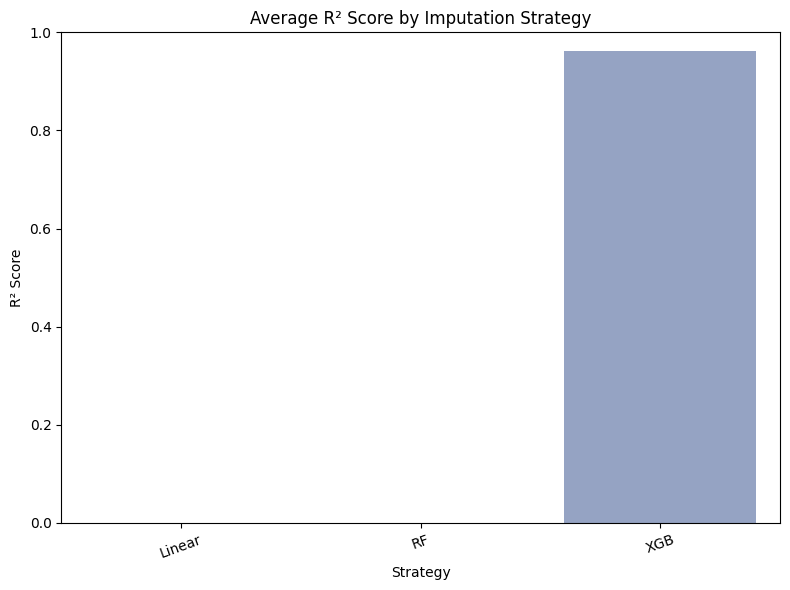

C:\Users\ZBOOK\AppData\Local\Temp\ipykernel_8364\2762994654.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_results, x="Strategy", y="accuracy", palette="Set1")


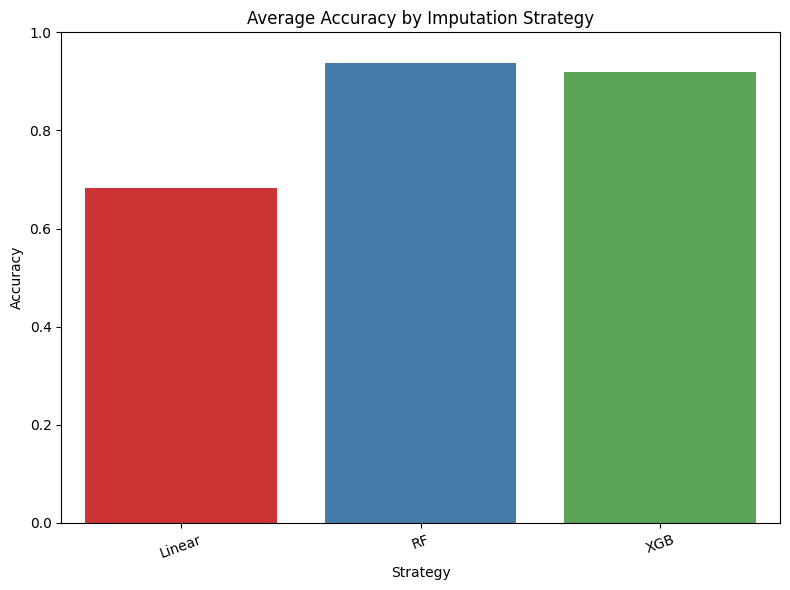

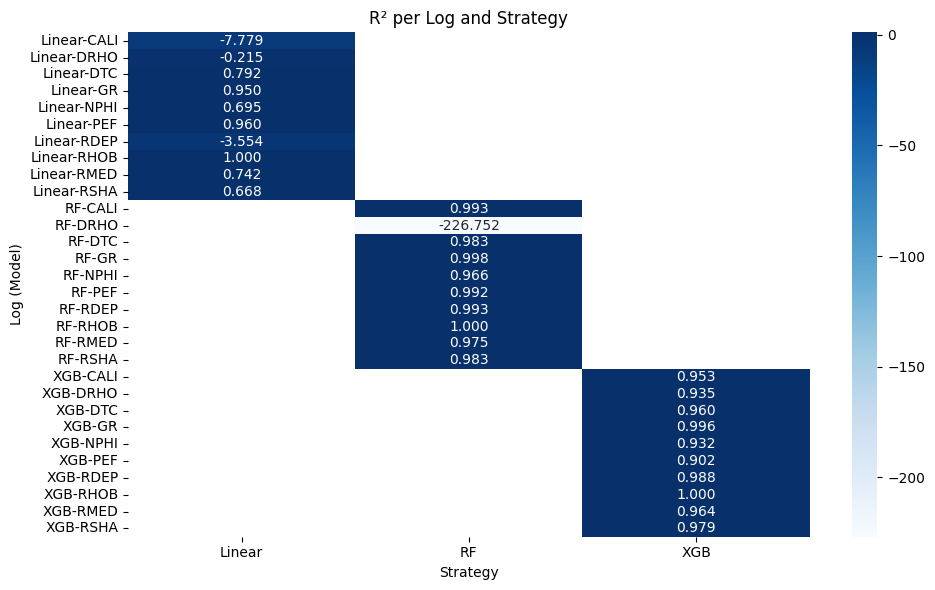

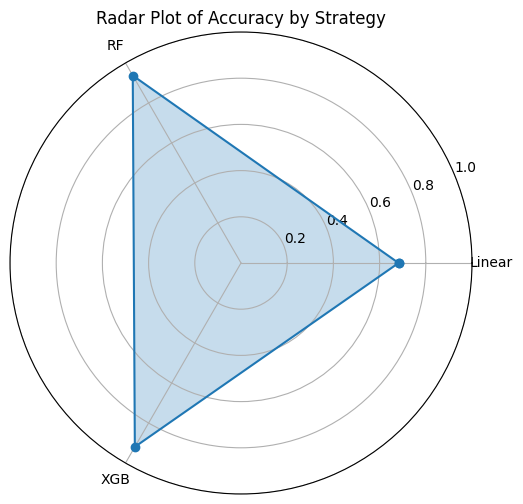


✅ Visualization complete.


In [17]:
results_dict = {
    "Linear": res_lin,
    "RF": res_rf,
    "XGB": res_xgb
}

plot_imputation_results(results_dict)

In [18]:
# Impute training wells only

# df_linear = impute_linear(df_train_raw, required_logs)
#df_rf  = impute_rf(df_train_raw, required_logs)
df_xgb  = impute_xgb(df_train_raw, required_logs)
# df_hybrid = impute_hybrid(df_train_raw, foundation_logs, resistivity_logs, advanced_logs)

print("\n✅ Imputation completed for training dataset only.")


--- XGBoost Imputation ---
ℹ️ Skipping GR: no missing values
✅ Filled 109410 missing values for RHOB using XGBoost with 22 features
✅ Filled 296943 missing values for NPHI using XGBoost with 22 features
✅ Filled 59875 missing values for CALI using XGBoost with 22 features
✅ Filled 10267 missing values for RDEP using XGBoost with 22 features
✅ Filled 28519 missing values for RMED using XGBoost with 22 features
✅ Filled 361218 missing values for RSHA using XGBoost with 22 features
✅ Filled 370234 missing values for PEF using XGBoost with 22 features
✅ Filled 128894 missing values for DRHO using XGBoost with 22 features
✅ Filled 41927 missing values for DTC using XGBoost with 22 features
=== Completed XGBoost Imputation ===

✅ Imputation completed for training dataset only.


In [19]:
# Recalculate engineered features after imputation

def prepare_features(df):
    
    # ---- Drop columns with too many missing values ----
    cols_to_drop = ["SGR", "RMIC", "DTS", "ROPA", "MUDWEIGHT", "RXO", "ROP", "BS"]
    df = df.drop(columns=[c for c in cols_to_drop if c in df], errors="ignore")
    
    # ---- Recalculate engineered features ----
    if "RHOB" in df: 
        df["Porosity_Index"] = (2.65 - df["RHOB"]) / (2.65 - 1.0)
    if "GR" in df: 
        df["Clay_Volume"] = ((df["GR"] - 20) / (150 - 20)).clip(0, 1)
    if all(c in df for c in ["RSHA", "RDEP"]):
        df["Invasion_Index"] = (df["RSHA"] - df["RDEP"]) / (df["RDEP"] + 1e-12)
    if all(c in df for c in ["PEF", "RHOB"]):
        df["Lithology_Factor"] = df["PEF"] / df["RHOB"]
    
    return df

# ---- Apply to training and testing datasets ----
df_train_prepared = prepare_features(df_xgb)
df_test_prepared  = prepare_features(df_test_raw)

# List of columns to drop due to too many missing values
cols_to_drop = ["SGR", "RMIC", "DTS", "ROPA", "MUDWEIGHT", "RXO", "ROP", "BS"]

# Drop them if they exist in the dataframe
df_test_prepared  = df_test_prepared .drop(columns=[c for c in cols_to_drop if c in df])

# ---- Optional: check missing values after preparation ----
missing_summary_train = pd.DataFrame({
    "missing_count": df_train_prepared.isna().sum(),
    "missing_pct": df_train_prepared.isna().mean() * 100
}).sort_values(by="missing_count", ascending=False)

missing_summary_test = pd.DataFrame({
    "missing_count": df_test_prepared.isna().sum(),
    "missing_pct": df_test_prepared.isna().mean() * 100
}).sort_values(by="missing_count", ascending=False)

print("=== Training Dataset Missing Values ===")
print(missing_summary_train[missing_summary_train["missing_count"] > 0])
print("\n=== Testing Dataset Missing Values ===")
print(missing_summary_test[missing_summary_test["missing_count"] > 0])

print("=== Training Dataset Columns ===")
print(df_train_prepared.columns.tolist())
print("\n=== Testing Dataset Columns ===")
print(df_test_prepared.columns.tolist())


=== Training Dataset Missing Values ===
                                   missing_count  missing_pct
SP                                        186569    22.059514
Y_LOC                                      10149     1.199996
Z_LOC                                      10149     1.199996
X_LOC                                      10149     1.199996
FORCE_2020_LITHOFACIES_CONFIDENCE            110     0.013006

=== Testing Dataset Missing Values ===
                                   missing_count  missing_pct
Invasion_Index                             99726    49.169222
RSHA                                       99635    49.124355
Lithology_Factor                           89245    44.001637
PEF                                        89208    43.983394
NPHI                                       81631    40.247606
SP                                         48417    23.871671
DRHO                                       37306    18.393468
RHOB                                       36995    


=== CV for RF_bin+RF_multi ===
Fold 1: Weighted F1 = 0.7632
Fold 2: Weighted F1 = 0.5890
Fold 3: Weighted F1 = 0.7265
Fold 4: Weighted F1 = 0.7184
Fold 5: Weighted F1 = 0.7522
Average CV Weighted F1: 0.7099

Final Test Weighted F1: 0.7183
              precision    recall  f1-score   support

       30000       0.61      0.72      0.66     29676
       65000       0.84      0.87      0.86    123410
       65030       0.44      0.21      0.28     27753
       70000       0.52      0.74      0.61     12123
       70032       0.00      0.00      0.00       994
       74000       0.02      0.00      0.01       446
       80000       0.38      0.53      0.45      4485
       86000       0.00      0.00      0.00        28
       90000       0.79      0.38      0.52       924
       99000       0.83      0.80      0.81      2983

    accuracy                           0.73    202822
   macro avg       0.44      0.43      0.42    202822
weighted avg       0.72      0.73      0.72    202822



C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


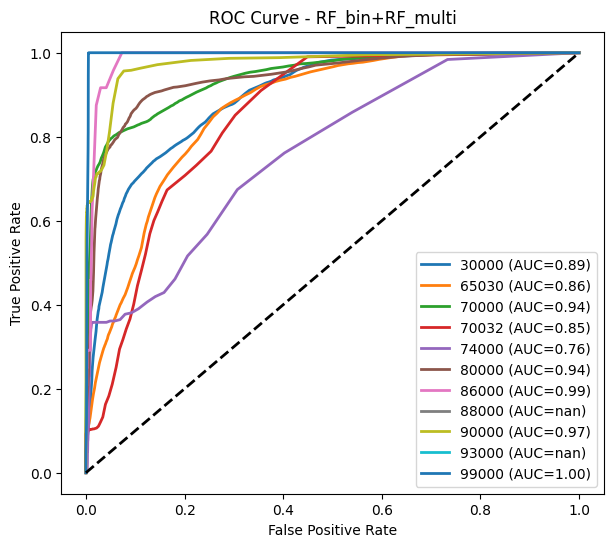


=== CV for RF_bin+XGB_multi ===


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [09:20:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1: Weighted F1 = 0.7554


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [09:23:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2: Weighted F1 = 0.6014


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [09:26:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3: Weighted F1 = 0.7260


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [09:29:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4: Weighted F1 = 0.7230


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [09:32:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5: Weighted F1 = 0.7609
Average CV Weighted F1: 0.7133


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [09:36:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Final Test Weighted F1: 0.7170
              precision    recall  f1-score   support

       30000       0.60      0.68      0.64     29676
       65000       0.84      0.87      0.86    123410
       65030       0.43      0.23      0.29     27753
       70000       0.53      0.77      0.63     12123
       70032       0.00      0.00      0.00       994
       74000       0.26      0.04      0.07       446
       80000       0.40      0.50      0.45      4485
       86000       0.00      0.00      0.00        28
       88000       0.00      0.00      0.00         0
       90000       0.77      0.38      0.51       924
       99000       0.77      0.76      0.77      2983

    accuracy                           0.73    202822
   macro avg       0.42      0.39      0.38    202822
weighted avg       0.72      0.73      0.72    202822



C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


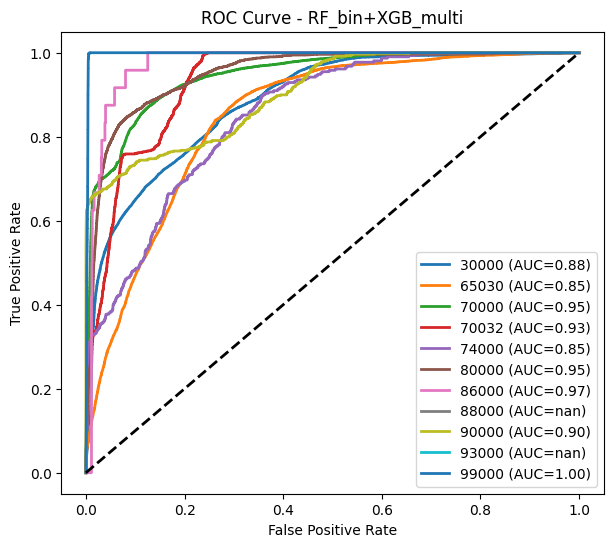


=== CV for RF_bin+CB_multi ===


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 1: Weighted F1 = 0.7456


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 2: Weighted F1 = 0.6067


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 3: Weighted F1 = 0.7326


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 4: Weighted F1 = 0.7131


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 5: Weighted F1 = 0.7674
Average CV Weighted F1: 0.7131


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Final Test Weighted F1: 0.7205
              precision    recall  f1-score   support

       30000       0.59      0.73      0.65     29676
       65000       0.84      0.87      0.86    123410
       65030       0.42      0.22      0.29     27753
       70000       0.64      0.72      0.68     12123
       70032       0.00      0.00      0.00       994
       74000       0.07      0.01      0.02       446
       80000       0.33      0.49      0.39      4485
       86000       0.00      0.00      0.00        28
       90000       0.81      0.37      0.51       924
       99000       0.79      0.80      0.79      2983

    accuracy                           0.74    202822
   macro avg       0.45      0.42      0.42    202822
weighted avg       0.72      0.74      0.72    202822



C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


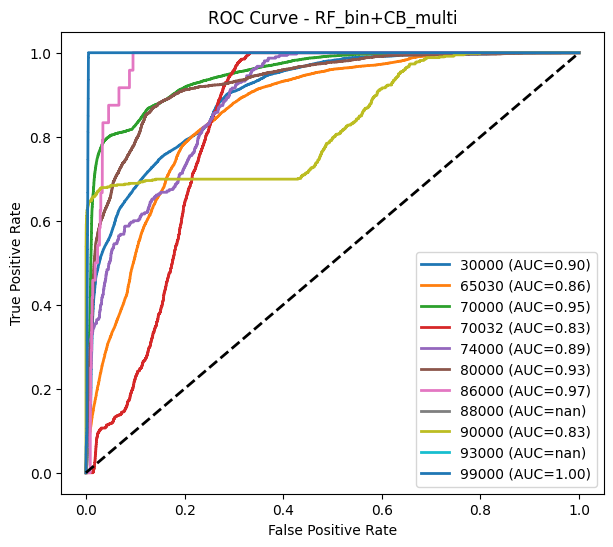


=== CV for RF_bin+LR_multi ===


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1: Weighted F1 = 0.6295


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2: Weighted F1 = 0.5014


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3: Weighted F1 = 0.6390


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4: Weighted F1 = 0.5857


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5: Weighted F1 = 0.6264
Average CV Weighted F1: 0.5964


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Final Test Weighted F1: 0.6158
              precision    recall  f1-score   support

       30000       0.33      0.70      0.45     29676
       65000       0.84      0.87      0.86    123410
       65030       0.33      0.15      0.20     27753
       70000       0.00      0.00      0.00     12123
       70032       0.00      0.00      0.00       994
       74000       0.00      0.00      0.00       446
       80000       0.00      0.00      0.00      4485
       86000       0.00      0.00      0.00        28
       90000       0.00      0.00      0.00       924
       99000       0.00      0.00      0.00      2983

    accuracy                           0.65    202822
   macro avg       0.15      0.17      0.15    202822
weighted avg       0.61      0.65      0.62    202822



C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


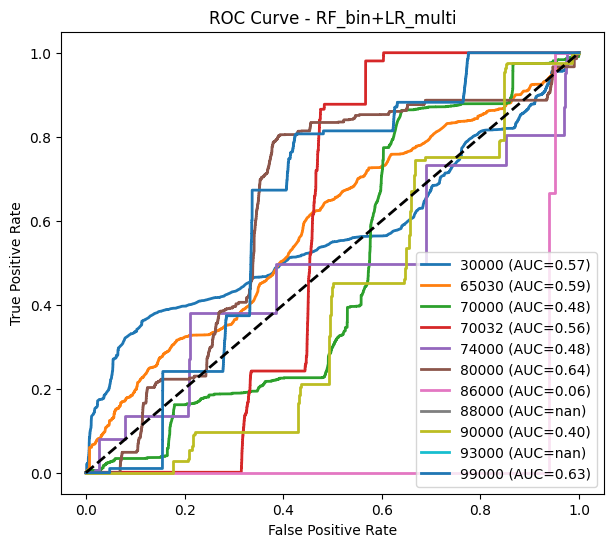


=== CV for XGB_bin+RF_multi ===


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:34:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1: Weighted F1 = 0.7534


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:36:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2: Weighted F1 = 0.6200


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:37:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3: Weighted F1 = 0.7359


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:39:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4: Weighted F1 = 0.7135


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:40:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5: Weighted F1 = 0.7371
Average CV Weighted F1: 0.7120


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:42:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Final Test Weighted F1: 0.7245
              precision    recall  f1-score   support

       30000       0.64      0.73      0.68     29676
       65000       0.84      0.88      0.86    123410
       65030       0.42      0.20      0.27     27753
       70000       0.59      0.74      0.65     12123
       70032       0.00      0.00      0.00       994
       74000       0.02      0.00      0.01       446
       80000       0.32      0.58      0.41      4485
       86000       0.00      0.00      0.00        28
       90000       0.83      0.38      0.53       924
       99000       0.82      0.94      0.88      2983

    accuracy                           0.74    202822
   macro avg       0.45      0.44      0.43    202822
weighted avg       0.72      0.74      0.72    202822



C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


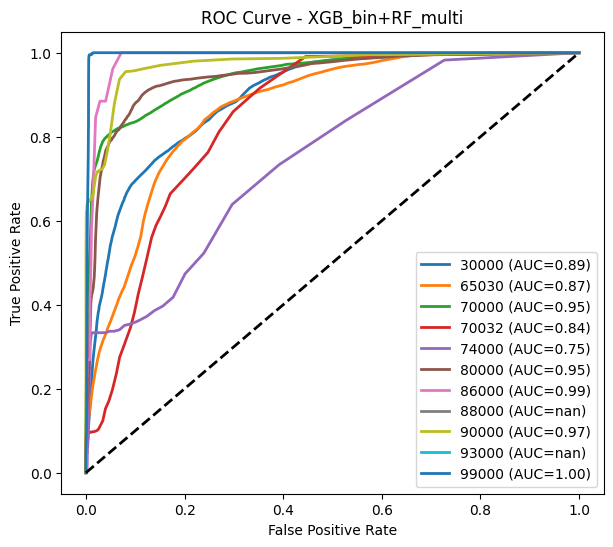


=== CV for XGB_bin+XGB_multi ===


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:45:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:45:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1: Weighted F1 = 0.7458


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:46:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:46:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2: Weighted F1 = 0.6349


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:47:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:47:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3: Weighted F1 = 0.7363


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:48:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:49:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4: Weighted F1 = 0.7164


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:50:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:50:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5: Weighted F1 = 0.7449
Average CV Weighted F1: 0.7157


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:51:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:51:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Final Test Weighted F1: 0.7214
              precision    recall  f1-score   support

       30000       0.64      0.69      0.66     29676
       65000       0.84      0.88      0.86    123410
       65030       0.41      0.21      0.28     27753
       70000       0.55      0.76      0.64     12123
       70032       0.00      0.00      0.00       994
       74000       0.28      0.04      0.07       446
       80000       0.34      0.54      0.42      4485
       86000       0.00      0.00      0.00        28
       88000       0.00      0.00      0.00         0
       90000       0.80      0.39      0.53       924
       99000       0.74      0.90      0.81      2983

    accuracy                           0.74    202822
   macro avg       0.42      0.40      0.39    202822
weighted avg       0.72      0.74      0.72    202822



C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


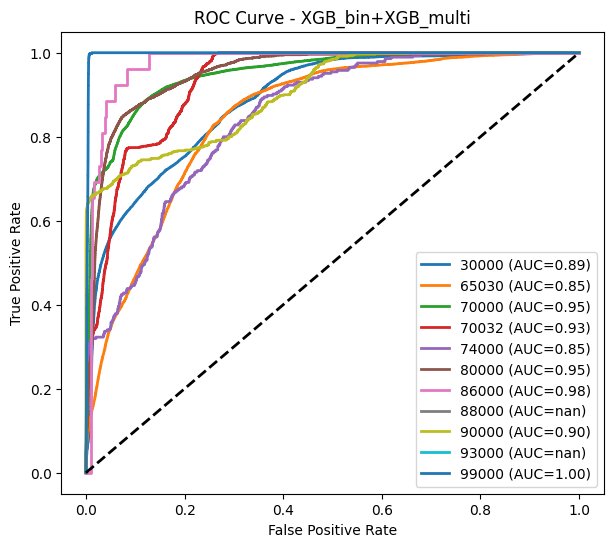


=== CV for XGB_bin+CB_multi ===


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:53:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 1: Weighted F1 = 0.7336


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:55:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 2: Weighted F1 = 0.6546


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:58:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 3: Weighted F1 = 0.7427


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:00:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 4: Weighted F1 = 0.7092


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:02:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 5: Weighted F1 = 0.7471
Average CV Weighted F1: 0.7175


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:04:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Final Test Weighted F1: 0.7254
              precision    recall  f1-score   support

       30000       0.64      0.73      0.68     29676
       65000       0.84      0.88      0.86    123410
       65030       0.39      0.21      0.27     27753
       70000       0.68      0.72      0.70     12123
       70032       0.00      0.00      0.00       994
       74000       0.09      0.01      0.02       446
       80000       0.27      0.53      0.36      4485
       86000       0.00      0.00      0.00        28
       90000       0.84      0.37      0.51       924
       99000       0.76      0.94      0.84      2983

    accuracy                           0.74    202822
   macro avg       0.45      0.44      0.42    202822
weighted avg       0.72      0.74      0.73    202822



C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


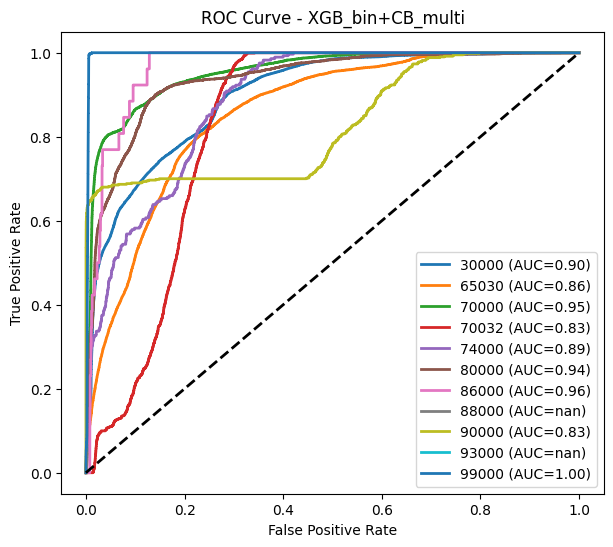


=== CV for XGB_bin+LR_multi ===


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:07:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Fold 1: Weighted F1 = 0.6172


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:08:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Fold 2: Weighted F1 = 0.5168


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:09:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Fold 3: Weighted F1 = 0.6485


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:11:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Fold 4: Weighted F1 = 0.5782


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:12:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Fold 5: Weighted F1 = 0.6194
Average CV Weighted F1: 0.5960


C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:13:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZBOOK\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   


Final Test Weighted F1: 0.6215
              precision    recall  f1-score   support

       30000       0.34      0.70      0.46     29676
       65000       0.84      0.88      0.86    123410
       65030       0.33      0.16      0.22     27753
       70000       0.00      0.00      0.00     12123
       70032       0.00      0.00      0.00       994
       74000       0.00      0.00      0.00       446
       80000       0.00      0.00      0.00      4485
       86000       0.00      0.00      0.00        28
       90000       0.00      0.00      0.00       924
       99000       0.00      0.00      0.00      2983

    accuracy                           0.66    202822
   macro avg       0.15      0.17      0.15    202822
weighted avg       0.61      0.66      0.62    202822



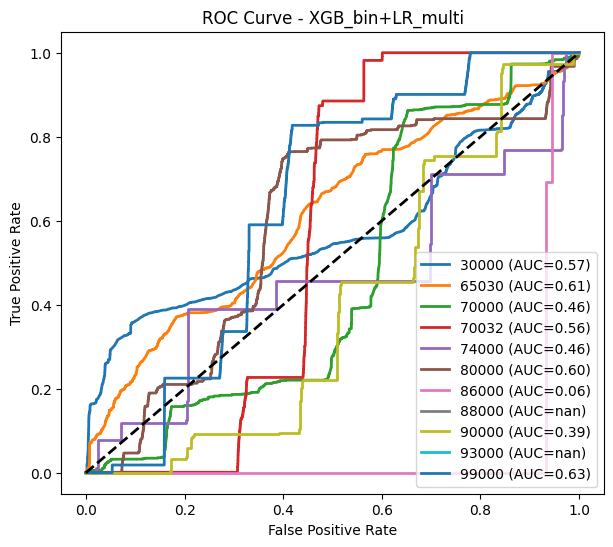


=== Summary ===
RF_bin+RF_multi_CV: 0.7099
RF_bin+RF_multi_Test: 0.7183
RF_bin+XGB_multi_CV: 0.7133
RF_bin+XGB_multi_Test: 0.7170
RF_bin+CB_multi_CV: 0.7131
RF_bin+CB_multi_Test: 0.7205
RF_bin+LR_multi_CV: 0.5964
RF_bin+LR_multi_Test: 0.6158
XGB_bin+RF_multi_CV: 0.7120
XGB_bin+RF_multi_Test: 0.7245
XGB_bin+XGB_multi_CV: 0.7157
XGB_bin+XGB_multi_Test: 0.7214
XGB_bin+CB_multi_CV: 0.7175
XGB_bin+CB_multi_Test: 0.7254
XGB_bin+LR_multi_CV: 0.5960
XGB_bin+LR_multi_Test: 0.6215


In [20]:
# ==============================================
# ===== Facies prediction with CV + Test ======
# ==============================================

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, classification_report, roc_curve, auc
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd


def to_f32(a):
    return np.asarray(a, dtype=np.float32)


def plot_roc_curves(y_true, y_proba, model_name, facies_labels):
    """Plot ROC curves per class and macro-average."""
    plt.figure(figsize=(7, 6))
    n_classes = len(facies_labels)

    # One-vs-rest ROC
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{facies_labels[i]} (AUC={roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()


def facies_prediction_cv_and_test(train_df, test_df, shale_code=65000, n_splits=5):
    target_col = "FORCE_2020_LITHOFACIES_LITHOLOGY"

    # === Data split ===
    X = train_df.drop(columns=[target_col, "WELL"], errors="ignore")
    y = train_df[target_col]
    groups = train_df["WELL"]  # well-based CV

    X_test = test_df.drop(columns=[target_col, "WELL"], errors="ignore")
    y_test = test_df[target_col]

    # === Models ===
    bin_models = {
        "RF_bin": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42),
        "XGB_bin": XGBClassifier(
            n_estimators=300, max_depth=6, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            tree_method="hist", eval_metric="mlogloss",
            random_state=42, use_label_encoder=False
        )
    }

    multi_models = {
        "RF_multi": RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
        "XGB_multi": XGBClassifier(
            n_estimators=400, max_depth=8, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            tree_method="hist", eval_metric="mlogloss",
            random_state=42, use_label_encoder=False
        ),
        "CB_multi": CatBoostClassifier(
            iterations=300, depth=8, learning_rate=0.05,
            task_type="GPU" if torch.cuda.is_available() else "CPU",
            verbose=0, random_state=42
        ),
        "LR_multi": LogisticRegression(
            max_iter=1000, multi_class="multinomial", solver="lbfgs"
        )
    }

    results = {}

    gkf = GroupKFold(n_splits=n_splits)

    # === CV Loop ===
    for bin_name, bin_clf in bin_models.items():
        for multi_name, multi_clf in multi_models.items():
            cv_f1_scores = []
            print(f"\n=== CV for {bin_name}+{multi_name} ===")

            for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
                X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
                y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

                # Stage 1 Binary
                y_train_bin = (y_train_fold == shale_code).astype(int)
                y_val_bin = (y_val_fold == shale_code).astype(int)

                imp_bin = SimpleImputer(strategy="mean")
                X_train_bin = imp_bin.fit_transform(X_train_fold)
                X_val_bin = imp_bin.transform(X_val_fold)

                bin_clf.fit(X_train_bin, y_train_bin)
                y_pred_bin = bin_clf.predict(X_val_bin)

                # Stage 2 Multi-class
                non_shale_idx = np.where(y_pred_bin == 0)[0]
                y_pred_full = np.array([shale_code if p == 1 else -1 for p in y_pred_bin])

                if len(non_shale_idx) > 0:
                    ns_mask = y_train_fold != shale_code
                    X_train_ns = X_train_fold[ns_mask]
                    y_train_ns = y_train_fold[ns_mask]
                    X_val_ns = X_val_fold.iloc[non_shale_idx]

                    le_ns = LabelEncoder()
                    y_train_ns_enc = le_ns.fit_transform(y_train_ns)

                    imp_multi = SimpleImputer(strategy="mean")
                    X_train_ns_fit = imp_multi.fit_transform(X_train_ns)
                    X_val_ns_fit = imp_multi.transform(X_val_ns)

                    multi_clf.fit(X_train_ns_fit, y_train_ns_enc)
                    y_pred_ns = multi_clf.predict(X_val_ns_fit)

                    y_pred_full[non_shale_idx] = le_ns.inverse_transform(y_pred_ns)

                # Facies-level F1 for this fold
                f1 = f1_score(y_val_fold, y_pred_full, average="weighted")
                cv_f1_scores.append(f1)
                print(f"Fold {fold+1}: Weighted F1 = {f1:.4f}")

            avg_f1 = np.mean(cv_f1_scores)
            results[f"{bin_name}+{multi_name}_CV"] = avg_f1
            print(f"Average CV Weighted F1: {avg_f1:.4f}")

            # === Final Test Evaluation ===
            # Retrain on all training data
            y_train_bin_full = (y == shale_code).astype(int)
            imp_bin = SimpleImputer(strategy="mean")
            X_train_bin_full = imp_bin.fit_transform(X)
            X_test_bin = imp_bin.transform(X_test)

            bin_clf.fit(X_train_bin_full, y_train_bin_full)
            y_pred_bin_test = bin_clf.predict(X_test_bin)

            non_shale_idx = np.where(y_pred_bin_test == 0)[0]
            y_pred_full_test = np.array([shale_code if p == 1 else -1 for p in y_pred_bin_test])

            if len(non_shale_idx) > 0:
                ns_mask = y != shale_code
                X_train_ns = X[ns_mask]
                y_train_ns = y[ns_mask]
                X_test_ns = X_test.iloc[non_shale_idx]

                le_ns = LabelEncoder()
                y_train_ns_enc = le_ns.fit_transform(y_train_ns)

                imp_multi = SimpleImputer(strategy="mean")
                X_train_ns_fit = imp_multi.fit_transform(X_train_ns)
                X_test_ns_fit = imp_multi.transform(X_test_ns)

                multi_clf.fit(X_train_ns_fit, y_train_ns_enc)
                y_pred_ns = multi_clf.predict(X_test_ns_fit)

                y_pred_full_test[non_shale_idx] = le_ns.inverse_transform(y_pred_ns)

            f1_test = f1_score(y_test, y_pred_full_test, average="weighted")
            results[f"{bin_name}+{multi_name}_Test"] = f1_test
            print(f"\nFinal Test Weighted F1: {f1_test:.4f}")
            print(classification_report(y_test, y_pred_full_test, zero_division=0))

            # If model has predict_proba, plot ROC
            if hasattr(multi_clf, "predict_proba") and len(non_shale_idx) > 0:
                y_test_ns = y_test.iloc[non_shale_idx]
                mask_valid = y_test_ns != shale_code  # filter out shale if any slipped in
            
                if mask_valid.any():
                    y_test_ns_enc = le_ns.transform(y_test_ns[mask_valid])
                    y_proba_ns = multi_clf.predict_proba(X_test_ns_fit[mask_valid])
                    plot_roc_curves(y_test_ns_enc, y_proba_ns,
                                    f"{bin_name}+{multi_name}", le_ns.classes_)


    return results


# Run pipeline
results_facies = facies_prediction_cv_and_test(df_train_prepared, df_test_prepared)
print("\n=== Summary ===")
for k, v in results_facies.items():
    print(f"{k}: {v:.4f}")


             Strategy  Eval        F1
0     RF_bin+RF_multi    CV  0.709862
1     RF_bin+RF_multi  Test  0.718295
2    RF_bin+XGB_multi    CV  0.713334
3    RF_bin+XGB_multi  Test  0.716958
4     RF_bin+CB_multi    CV  0.713080
5     RF_bin+CB_multi  Test  0.720469
6     RF_bin+LR_multi    CV  0.596415
7     RF_bin+LR_multi  Test  0.615770
8    XGB_bin+RF_multi    CV  0.711992
9    XGB_bin+RF_multi  Test  0.724504
10  XGB_bin+XGB_multi    CV  0.715664
11  XGB_bin+XGB_multi  Test  0.721438
12   XGB_bin+CB_multi    CV  0.717451
13   XGB_bin+CB_multi  Test  0.725408
14   XGB_bin+LR_multi    CV  0.596030
15   XGB_bin+LR_multi  Test  0.621492

=== Results DataFrame ===
             Strategy  Eval        F1
0     RF_bin+RF_multi    CV  0.709862
1     RF_bin+RF_multi  Test  0.718295
2    RF_bin+XGB_multi    CV  0.713334
3    RF_bin+XGB_multi  Test  0.716958
4     RF_bin+CB_multi    CV  0.713080
5     RF_bin+CB_multi  Test  0.720469
6     RF_bin+LR_multi    CV  0.596415
7     RF_bin+LR_multi  

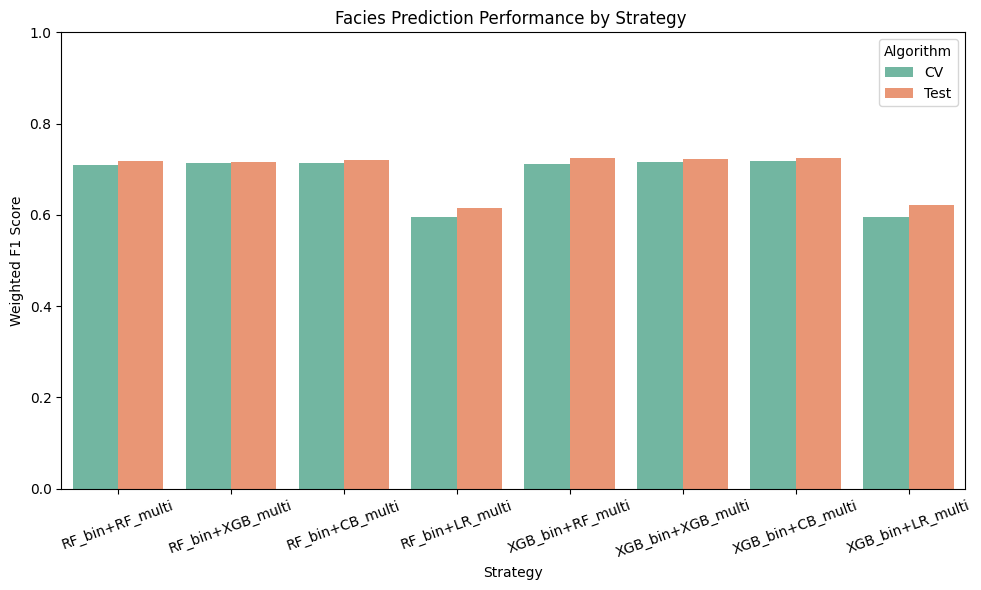


📊 Plot 2: Side-by-side comparison of Evaluation per Strategy...


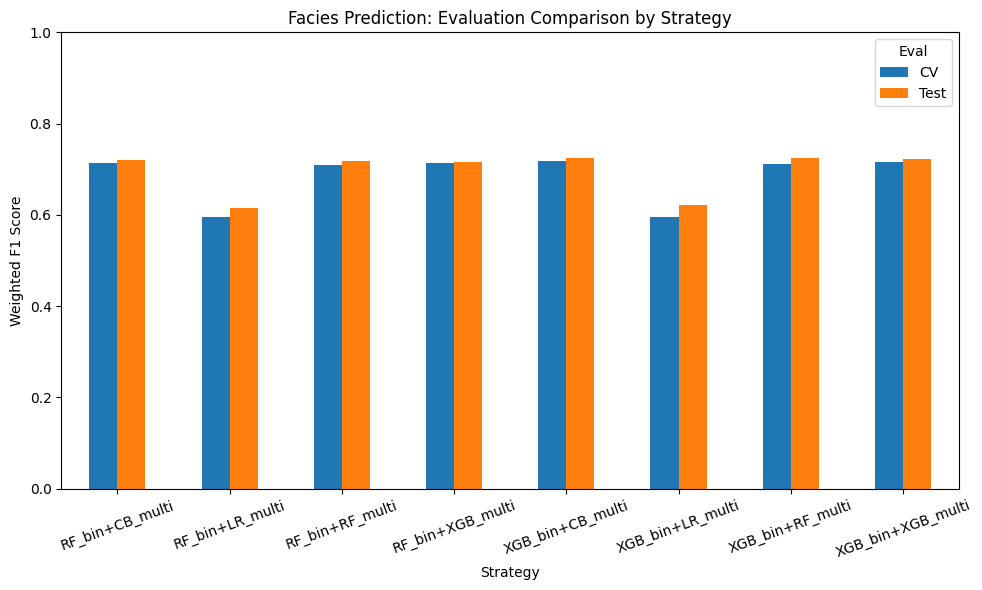


📊 Plot 3: Heatmap of performance...


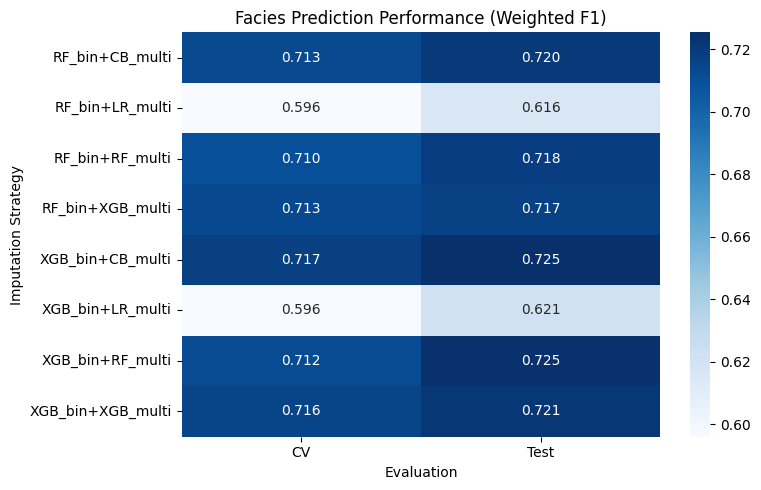


Visualization complete.


In [21]:
# ==============================================
# =========== Comparative Results ==============
# ==============================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert into flat DataFrame
results_flat = []
for key, score in results_facies.items():
    # Split key into parts: "Strategy" and "Evaluation"
    if "_CV" in key:
        strategy = key.replace("_CV", "")
        eval_type = "CV"
    elif "_Test" in key:
        strategy = key.replace("_Test", "")
        eval_type = "Test"
    else:
        strategy, eval_type = key, "Unknown"

    results_flat.append({
        "Strategy": strategy,
        "Eval": eval_type,
        "F1": score
    })

results_df = pd.DataFrame(results_flat)
print(results_df)


results_df = pd.DataFrame(results_flat)

print("\n=== Results DataFrame ===")
if results_df.empty:
    print("❌ No results to display. Please run facies_prediction_multi first.")
else:
    print(results_df)

# 1. Barplot of F1 scores by Strategy
if not results_df.empty:
    print("\n📊 Plot 1: Barplot of F1 scores by Strategy...")
    plt.figure(figsize=(10,6))
    sns.barplot(data=results_df, x="Strategy", y="F1", hue="Eval", palette="Set2")
    plt.title("Facies Prediction Performance by Strategy ")
    plt.ylabel("Weighted F1 Score")
    plt.ylim(0,1)
    plt.xticks(rotation=20)
    plt.legend(title="Algorithm")
    plt.tight_layout()
    plt.show()

# 2. Side-by-side comparison per Strategy
if not results_df.empty:
    print("\n📊 Plot 2: Side-by-side comparison of Evaluation per Strategy...")
    pivot_df = results_df.pivot(index="Strategy", columns="Eval", values="F1")
    pivot_df.plot(kind="bar", figsize=(10,6), rot=20)
    plt.title("Facies Prediction: Evaluation Comparison by Strategy")
    plt.ylabel("Weighted F1 Score")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

# 3. Heatmap 
if not results_df.empty:
    print("\n📊 Plot 3: Heatmap of performance...")
    plt.figure(figsize=(8,5))
    sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="Blues", cbar=True)
    plt.title("Facies Prediction Performance (Weighted F1)")
    plt.ylabel("Imputation Strategy")
    plt.xlabel("Evaluation")
    plt.tight_layout()
    plt.show()

print("\nVisualization complete.")



📊 Plot 5: Lineplot per Strategy...


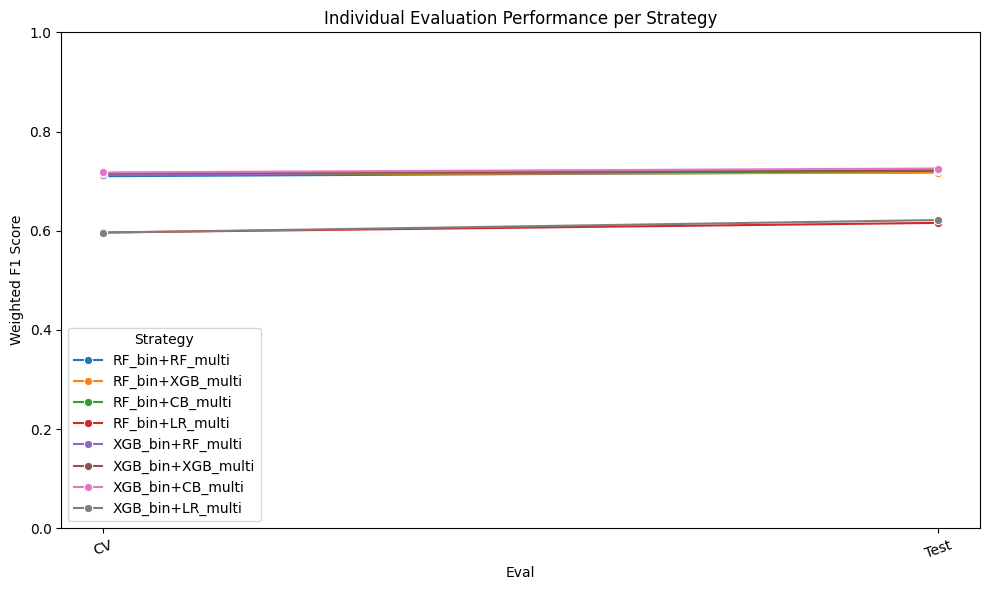


📊 Plot 6: Boxplot of F1 across Strategies for each Evaluation...


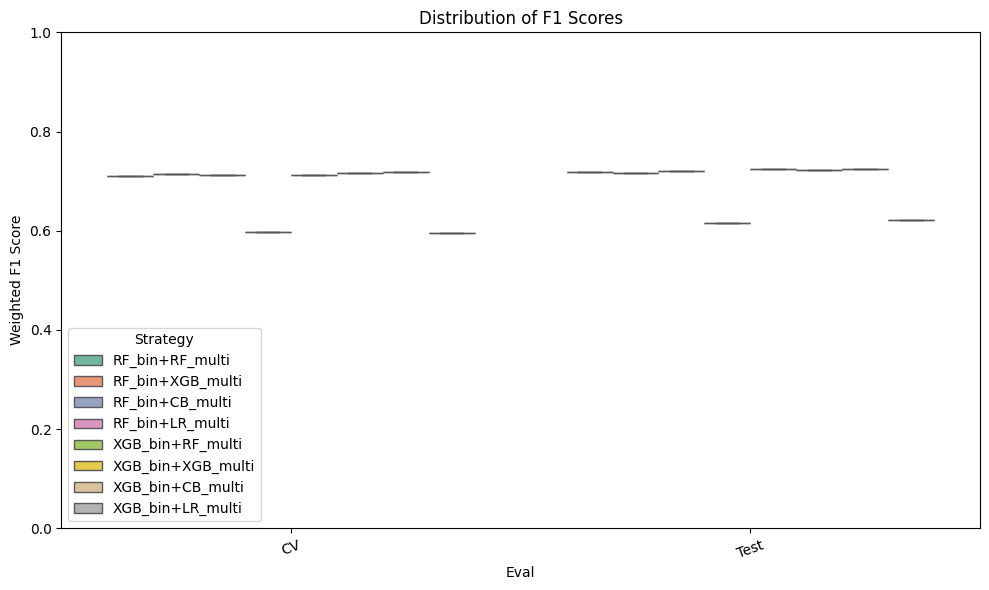


📊 Plot 7: Scatter plot of individual results...


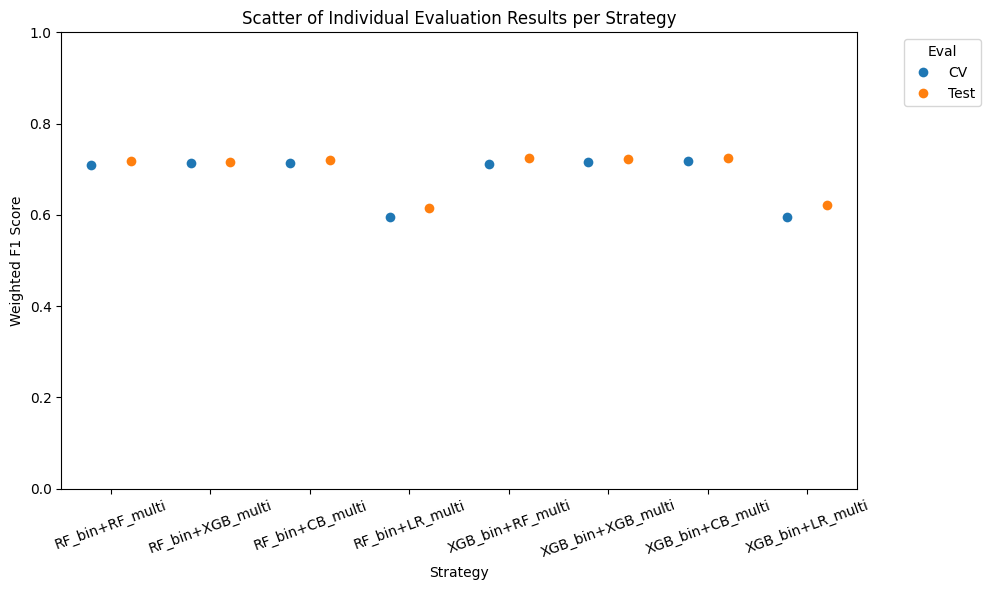

In [22]:
# ==============================================
# ============= Individual Results =============
# ==============================================

# 5. Lineplot per Strategy (individual algorithm curves)
if not results_df.empty:
    print("\n📊 Plot 5: Lineplot per Strategy...")
    plt.figure(figsize=(10,6))
    sns.lineplot(data=results_df, x="Eval", y="F1", hue="Strategy", marker="o")
    plt.title("Individual Evaluation Performance per Strategy")
    plt.ylabel("Weighted F1 Score")
    plt.ylim(0,1)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

# 6. Boxplot per Algorithm (variation across strategies)
if not results_df.empty:
    print("\n📊 Plot 6: Boxplot of F1 across Strategies for each Evaluation...")
    plt.figure(figsize=(10,6))
    sns.boxplot(data=results_df, x="Eval", y="F1", hue="Strategy", palette="Set2")
    plt.title("Distribution of F1 Scores")
    plt.ylabel("Weighted F1 Score")
    plt.ylim(0,1)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

# 7. Scatter plot (Strategy vs F1 per Algorithm)
if not results_df.empty:
    print("\n📊 Plot 7: Scatter plot of individual results...")
    plt.figure(figsize=(10,6))
    sns.stripplot(data=results_df, x="Strategy", y="F1", hue="Eval", jitter=True, dodge=True, size=7)
    plt.title("Scatter of Individual Evaluation Results per Strategy")
    plt.ylabel("Weighted F1 Score")
    plt.ylim(0,1)
    plt.xticks(rotation=20)
    plt.legend(title="Eval", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
